# Третье практическое задание. Реализация дропаута в рекуррентных нейронных сетях
Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: Григорьев Илья

Дата выдачи: 3 апреля 00:01

Мягкий дедлайн: 17 апреля 00:01

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# Часть 0. Загрузка и предобработка данных. (1 балл)

## Рекомендуемые гиперпараметры

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать -- скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## Загрузка и предобработка данных

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [2]:
# YOUR CODE HERE

Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [3]:
# YOUR CODE HERE

Посмотрите в файле `./aclImdb/README` как организованы данные

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [4]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [5]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np
import re

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torch import nn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти -- размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [6]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [7]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    text = text.lower()
    text = text.replace('<br />', '')
    text = re.sub('[^a-z ]', ' ', text, count=0)
    words = text.split()
    res = []
    for word in words:
        if word not in STOPWORDS:
            res.append(word)
    return res

In [8]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab`.

In [19]:
torchtext.vocab.Vocab??

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [9]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [10]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие id отдайте под специальные токены. Отбросьте низкочастотные слова, оставив только `top_n_words` слов

In [11]:
len(counter)

101252

In [12]:
vocab = torchtext.vocab.Vocab(counter, max_size=top_n_words, specials=specials)

In [13]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [14]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 254]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от 1 до 10. Для удобства, вычтите 1, чтобы рейтинг был от 0 до 9

In [15]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            text = open(path, 'r', encoding='utf-8', errors='ignore').read()
            self.texts.append(text)
            tokens = tokenize(text.strip())
            if len(tokens) > self.max_len:
                tokens = tokens[0:self.max_len]
            token_ids = self.vocab.lookup_indices(tokens)
            self.tokens.append(token_ids)
            rate = path[-6:-4]
            if rate[0] == '_':
                rate = int(rate[1]) - 1
            else:
                rate = 9
            self.ratings.append(rate)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.tensor(dtype=torch.long): rating of the text
                'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.tensor(dtype=torch.long): number of tokens
            }
        """
        # Do not forget to add padding if needed!
        tokens = self.tokens[idx]
        tokens_len = len(tokens)
        if self.pad_sos:
            tokens = [self.sos_id] + tokens
            tokens_len += 1
        if self.pad_eos:
            tokens = tokens + [self.eos_id]
            tokens_len += 1
        
        res = {'text': self.texts[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long), 
               'rating': torch.tensor(self.ratings[idx], dtype=torch.long), 
               'tokens': torch.tensor(tokens, dtype=torch.long), 
               'tokens_len': torch.tensor(tokens_len, dtype=torch.long)}
        return res
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.labels)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [16]:
test_dataset = LargeMovieReviewDataset(data_path=test_data_path, vocab=vocab, max_len=max_length)
train_dataset = LargeMovieReviewDataset(data_path=train_data_path, vocab=vocab, max_len=max_length)

Посмотрим, как выглядит объект в датасете:

In [17]:
test_dataset[0]

{'text': "Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.",
 'label': tensor(0),
 'rating': tensor(1),
 'tokens': tensor([ 315,    1, 3238,    2,  

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` -- число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [18]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [19]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    texts = []
    ratings = torch.tensor([], dtype=torch.long)
    labels = torch.tensor([], dtype=torch.long)
    tokens_lens = torch.tensor([], dtype=torch.long)
    tokens_list = []
    for data in batch:
        texts.append(data['text'])
        ratings = torch.hstack((ratings, data['rating']))
        labels = torch.hstack((labels, data['label']))
        tokens_lens = torch.hstack((tokens_lens, data['tokens_len']))
        tokens_list.append(data['tokens'])
    tokens = torch.nn.utils.rnn.pad_sequence(tokens_list, batch_first=batch_first, padding_value=padding_value)
    res = {'ratings': ratings, 'labels': labels, 'texts': texts, 'tokens': tokens, 'tokens_lens': tokens_lens}
    return res

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [20]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, padding_value=0))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, padding_value=0))

Посмотрим на какой-нибудь батч:

In [21]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 3, 0, 2, 2, 1, 1, 1, 3, 3, 2, 2, 1, 0, 0, 3, 1, 3, 2, 0, 0, 0, 3, 0,
         2, 3, 3, 2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 0, 0,
         0, 1, 0, 3, 0, 0, 0, 3, 3, 1, 3, 3, 2, 0, 0, 0]),
 tensor([[ 315,  342,   20,  ..., 2230,  607,    1],
         [   1, 2080,  595,  ...,  127,    1,  282],
         [3238,  100, 4991,  ...,   58,  527,  474],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([ 73, 126, 110, 164, 139,  55,  77,  70,  72,  99,  58, 142, 142,  50,
         102, 114,  65, 115, 190,  47,  37,  93, 200, 200, 135, 107, 103, 20

# Часть 1. Классификация текстов. (6 баллов)

## Сборка и обучение RNN в pytorch (2 балла)

Создадим переменные для device-agnostic кода:

In [22]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-ембеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

In [23]:
len(vocab)

5002

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [24]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE
        self.word_embeddings = nn.Embedding(len(vocab), embedding_dim, padding_idx=vocab.lookup_indices(['<pad>'])[0])
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        # YOUR CODE HERE
        self.output = nn.Linear(in_features=hidden_dim, out_features=output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # YOUR CODE HERE
        # (200, 64, 32)
        input_tensor = self.word_embeddings(tokens)
        
        # Make forward pass through recurrent network
        # YOUR CODE HERE
        # (200, 64, 128)
        output_tensor, (h_n, c_n) = self.rnn(input_tensor)
        
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        # YOUR CODE HERE
        # (64, 128)
        output_tensor = output_tensor[tokens_lens - 1, np.arange(output_tensor.shape[1]), ...]
        return self.output(output_tensor)

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [53]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model = model.to(device)
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        optimizer.zero_grad()
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        ratings = data['ratings'].to(device)
        outputs = model(tokens, tokens_lens)
        loss = loss_fn(outputs, ratings)
        loss.backward()
        optimizer.step()
    
def evaluate(dataloader, model, loss_fn, device):
    model = model.to(device)
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            ratings = data['ratings'].to(device)
            labels = data['labels'].numpy()
            outputs = model(tokens, tokens_lens)
            loss = loss_fn(outputs, ratings).cpu().item()
            total_loss += loss
            outputs = outputs.cpu().numpy()
            # ratings = ratings.cpu().numpy()
            outputs = np.argmax(outputs, axis=1)
            outputs[outputs <= 4] = 0
            outputs[outputs > 0] = 1
            acc = (outputs == labels).sum()
            total_accuracy += acc
        
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [54]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [55]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [56]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 0.031/0.031. Accuracy (Train/Test): 0.583/0.583
Epoch: 2/15. Loss (Train/Test): 0.027/0.027. Accuracy (Train/Test): 0.805/0.794
Epoch: 3/15. Loss (Train/Test): 0.025/0.026. Accuracy (Train/Test): 0.858/0.834
Epoch: 4/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.878/0.848
Epoch: 5/15. Loss (Train/Test): 0.022/0.024. Accuracy (Train/Test): 0.889/0.850
Epoch: 6/15. Loss (Train/Test): 0.022/0.024. Accuracy (Train/Test): 0.904/0.860
Epoch: 7/15. Loss (Train/Test): 0.021/0.024. Accuracy (Train/Test): 0.909/0.854
Epoch: 8/15. Loss (Train/Test): 0.020/0.024. Accuracy (Train/Test): 0.928/0.863
Epoch: 9/15. Loss (Train/Test): 0.019/0.025. Accuracy (Train/Test): 0.933/0.860
Epoch: 10/15. Loss (Train/Test): 0.018/0.025. Accuracy (Train/Test): 0.946/0.860
Epoch: 11/15. Loss (Train/Test): 0.017/0.026. Accuracy (Train/Test): 0.950/0.855
Epoch: 12/15. Loss (Train/Test): 0.016/0.027. Accuracy (Train/Test): 0.964/0.858
Epoch: 13/15. Loss (Train/Test): 0.01

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют L2-регуляризацию и дропаут.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## Реализация дропаута по статье Гала и Гарамани. Variational Dropout. (1 балл)

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$

In [57]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    # YOUR CODE HERE
    return some_existing_tensor.new_zeros((num_objects, hidden_size)), some_existing_tensor.new_zeros((num_objects, hidden_size))

In [58]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    # YOUR CODE HERE
    if p is None:
        return some_existing_tensor.new_ones(input_size), some_existing_tensor.new_ones(hidden_size)
    else:
        if is_training:
            return torch.bernoulli(torch.tensor([p] * input_size)), torch.bernoulli(torch.tensor([p] * hidden_size))
        else:
            return torch.bernoulli(torch.tensor([1 - p] * input_size)), torch.bernoulli(torch.tensor([1 - p] * hidden_size))

Допишите класс-обёртку над LSTMCell для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [59]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, torch.tensor((), dtype=torch.float32))
        # (64, 128)
        h_0 = h_0.to(device)
        # (64, 128)
        c_0 = c_0.to(device)
        
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        input_mask, hidden_mask = gen_dropout_mask(self.input_size, self.hidden_size, False, self.dropout, torch.tensor((), dtype=torch.int32))
        # (64, 32)
        input_mask = torch.tile(input_mask, (x.shape[1], 1)).to(device)
        # (64, 128)
        hidden_mask = torch.tile(hidden_mask, (x.shape[1], 1)).to(device)
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        h_res = torch.tensor([], dtype=torch.float32).to(device)
        for time in range(x.shape[0]):
            h_0, c_0 = self.rnn_cell(x[time, ...] * input_mask, (h_0 * hidden_mask, c_0))
            h_res = torch.cat((h_res, torch.unsqueeze(h_0, 0)))
        # h_res shape is (200, 64, 128)
        return h_res, (h_0, c_0)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [60]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=None
).to(device)

In [61]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
%%time

train_losses_do11, train_accuracies_do11, test_losses_do11, test_accuracies_do11 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 0.030/0.030. Accuracy (Train/Test): 0.710/0.706
Epoch: 2/15. Loss (Train/Test): 0.026/0.027. Accuracy (Train/Test): 0.826/0.808
Epoch: 3/15. Loss (Train/Test): 0.025/0.026. Accuracy (Train/Test): 0.862/0.833
Epoch: 4/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.879/0.843
Epoch: 5/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.890/0.849
Epoch: 6/15. Loss (Train/Test): 0.022/0.024. Accuracy (Train/Test): 0.906/0.854
Epoch: 7/15. Loss (Train/Test): 0.021/0.025. Accuracy (Train/Test): 0.913/0.855
Epoch: 8/15. Loss (Train/Test): 0.020/0.025. Accuracy (Train/Test): 0.929/0.859
Epoch: 9/15. Loss (Train/Test): 0.019/0.025. Accuracy (Train/Test): 0.935/0.855
Epoch: 10/15. Loss (Train/Test): 0.018/0.026. Accuracy (Train/Test): 0.950/0.856
Epoch: 11/15. Loss (Train/Test): 0.017/0.026. Accuracy (Train/Test): 0.958/0.854
Epoch: 12/15. Loss (Train/Test): 0.016/0.027. Accuracy (Train/Test): 0.965/0.854
Epoch: 13/15. Loss (Train/Test): 0.01

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [63]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0.25
).to(device)

In [64]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
%%time

train_losses_do12, train_accuracies_do12, test_losses_do12, test_accuracies_do12 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 0.032/0.032. Accuracy (Train/Test): 0.554/0.549
Epoch: 2/15. Loss (Train/Test): 0.030/0.030. Accuracy (Train/Test): 0.678/0.661
Epoch: 3/15. Loss (Train/Test): 0.027/0.028. Accuracy (Train/Test): 0.781/0.775
Epoch: 4/15. Loss (Train/Test): 0.026/0.027. Accuracy (Train/Test): 0.810/0.800
Epoch: 5/15. Loss (Train/Test): 0.025/0.026. Accuracy (Train/Test): 0.834/0.822
Epoch: 6/15. Loss (Train/Test): 0.025/0.026. Accuracy (Train/Test): 0.854/0.829
Epoch: 7/15. Loss (Train/Test): 0.024/0.025. Accuracy (Train/Test): 0.853/0.831
Epoch: 8/15. Loss (Train/Test): 0.024/0.025. Accuracy (Train/Test): 0.873/0.848
Epoch: 9/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.876/0.844
Epoch: 10/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.884/0.851
Epoch: 11/15. Loss (Train/Test): 0.022/0.025. Accuracy (Train/Test): 0.885/0.852
Epoch: 12/15. Loss (Train/Test): 0.022/0.025. Accuracy (Train/Test): 0.890/0.852
Epoch: 13/15. Loss (Train/Test): 0.02

## Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде домножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [34]:
import warnings

In [43]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            # YOUR CODE HERE
            input_mask, hidden_mask = gen_dropout_mask(self.input_size, self.hidden_size, False, self.dropout, torch.tensor((), dtype=torch.int32))
            hidden_mask = torch.tile(hidden_mask, (512, 1)).to(device)
            input_mask = torch.tile(input_mask, (512, 1)).to(device)

            # Apply dropout mask
            # YOUR CODE HERE
            if (raw_w.shape[1] == 128):
                masked_raw_w = raw_w * hidden_mask
            else:
                masked_raw_w = raw_w * input_mask

            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.tensor, torch.tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            # YOUR CODE HERE
            self._setweights(x)
            if h_c is None:
                output = self.module(x)
            else:
                output = self.module(x, h_c)
            return output
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [66]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=None
).to(device)

In [67]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
%%time

train_losses_do21, train_accuracies_do21, test_losses_do21, test_accuracies_do21 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 0.031/0.031. Accuracy (Train/Test): 0.610/0.600
Epoch: 2/15. Loss (Train/Test): 0.027/0.028. Accuracy (Train/Test): 0.788/0.776
Epoch: 3/15. Loss (Train/Test): 0.025/0.026. Accuracy (Train/Test): 0.847/0.824
Epoch: 4/15. Loss (Train/Test): 0.024/0.025. Accuracy (Train/Test): 0.861/0.832
Epoch: 5/15. Loss (Train/Test): 0.023/0.024. Accuracy (Train/Test): 0.888/0.855
Epoch: 6/15. Loss (Train/Test): 0.022/0.024. Accuracy (Train/Test): 0.901/0.860
Epoch: 7/15. Loss (Train/Test): 0.021/0.025. Accuracy (Train/Test): 0.907/0.856
Epoch: 8/15. Loss (Train/Test): 0.020/0.024. Accuracy (Train/Test): 0.919/0.864
Epoch: 9/15. Loss (Train/Test): 0.019/0.025. Accuracy (Train/Test): 0.927/0.864
Epoch: 10/15. Loss (Train/Test): 0.018/0.025. Accuracy (Train/Test): 0.938/0.862
Epoch: 11/15. Loss (Train/Test): 0.017/0.026. Accuracy (Train/Test): 0.945/0.860
Epoch: 12/15. Loss (Train/Test): 0.016/0.027. Accuracy (Train/Test): 0.948/0.856
Epoch: 13/15. Loss (Train/Test): 0.01

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [69]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)

In [70]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
%%time

train_losses_do22, train_accuracies_do22, test_losses_do22, test_accuracies_do22 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 0.031/0.031. Accuracy (Train/Test): 0.580/0.576
Epoch: 2/15. Loss (Train/Test): 0.029/0.029. Accuracy (Train/Test): 0.726/0.719
Epoch: 3/15. Loss (Train/Test): 0.028/0.028. Accuracy (Train/Test): 0.773/0.762
Epoch: 4/15. Loss (Train/Test): 0.026/0.027. Accuracy (Train/Test): 0.819/0.799
Epoch: 5/15. Loss (Train/Test): 0.025/0.026. Accuracy (Train/Test): 0.841/0.820
Epoch: 6/15. Loss (Train/Test): 0.024/0.025. Accuracy (Train/Test): 0.859/0.835
Epoch: 7/15. Loss (Train/Test): 0.024/0.025. Accuracy (Train/Test): 0.863/0.838
Epoch: 8/15. Loss (Train/Test): 0.024/0.025. Accuracy (Train/Test): 0.876/0.845
Epoch: 9/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.881/0.848
Epoch: 10/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.883/0.851
Epoch: 11/15. Loss (Train/Test): 0.023/0.025. Accuracy (Train/Test): 0.888/0.853
Epoch: 12/15. Loss (Train/Test): 0.022/0.024. Accuracy (Train/Test): 0.892/0.857
Epoch: 13/15. Loss (Train/Test): 0.02

</конец взлома pytorch>

## Реализация дропаута по статье Семениуты и др. (1 балл)

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток (m_h - маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [89]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x, hidden):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        h, c = hidden
        h = h.to(device)
        c = c.to(device)
        input_mask, hidden_mask = gen_dropout_mask(self.input_size, self.hidden_size, False, self.dropout, torch.tensor((), dtype=torch.int32))
        hidden_mask = hidden_mask.to(device)
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        h = h.view(h.size(1), -1)
        c = c.view(c.size(1), -1)
        x = x.view(x.size(1), -1)

        preact = self.input_weights(x) + self.hidden_weights(h)
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size]
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]

        c_t = torch.mul(c, f_t) + torch.mul(i_t, g_t) * hidden_mask
        h_t = torch.mul(o_t, c_t.tanh())

        h_t = h_t.view(1, h_t.size(0), -1)
        c_t = c_t.view(1, c_t.size(0), -1)
        return h_t, c_t

In [90]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = HandmadeLSTM(self.input_size, self.hidden_size, dropout)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h_0, c_0 = torch.tensor((), dtype=torch.float32).new_zeros(self.hidden_size), torch.tensor((), dtype=torch.float32).new_zeros(self.hidden_size)
        h_0 = h_0.to(device)
        c_0 = c_0.to(device)
        
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        input_mask, hidden_mask = gen_dropout_mask(self.input_size, self.hidden_size, False, self.dropout, torch.tensor((), dtype=torch.int32))
        input_mask = input_mask.to(device)
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        h_res = torch.tensor([], dtype=torch.float32).to(device)
        for time in range(x.shape[0]):
            h_0, c_0 = self.rnn_cell(x[time, ...] * input_mask, (h_0, c_0))
            h_res = torch.cat((h_res, torch.unsqueeze(h_0, 0)))
        # h_res shape is (200, 64, 128)
        return h_res, (h_0, c_0)

In [94]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=partial(collate_fn, padding_value=0))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial(collate_fn, padding_value=0))

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [95]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=None
).to(device)

In [96]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
%%time

train_losses_do31, train_accuracies_do31, test_losses_do31, test_accuracies_do31 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

In [41]:
# YOUR CODE HERE

Epoch: 1/15. Loss (Train/Test): 2.031/2.032. Accuracy (Train/Test): 0.216/0.213
Epoch: 2/15. Loss (Train/Test): 1.857/1.873. Accuracy (Train/Test): 0.317/0.320
Epoch: 3/15. Loss (Train/Test): 1.688/1.724. Accuracy (Train/Test): 0.351/0.352
Epoch: 4/15. Loss (Train/Test): 1.632/1.677. Accuracy (Train/Test): 0.363/0.344
Epoch: 5/15. Loss (Train/Test): 1.551/1.610. Accuracy (Train/Test): 0.394/0.374
Epoch: 6/15. Loss (Train/Test): 1.524/1.586. Accuracy (Train/Test): 0.404/0.379
Epoch: 7/15. Loss (Train/Test): 1.486/1.562. Accuracy (Train/Test): 0.416/0.393
Epoch: 8/15. Loss (Train/Test): 1.455/1.552. Accuracy (Train/Test): 0.427/0.398
Epoch: 9/15. Loss (Train/Test): 1.434/1.552. Accuracy (Train/Test): 0.435/0.397
Epoch: 10/15. Loss (Train/Test): 1.402/1.522. Accuracy (Train/Test): 0.444/0.405
Epoch: 11/15. Loss (Train/Test): 1.391/1.527. Accuracy (Train/Test): 0.450/0.408
Epoch: 12/15. Loss (Train/Test): 1.369/1.526. Accuracy (Train/Test): 0.459/0.405
Epoch: 13/15. Loss (Train/Test): 1.36

## Сравнение всех предложенных моделей. (1 балл)

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 1min 57s      | 10min 2s | 2min 12s     | 31m 44s      |

In [104]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [99]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика -- функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

The PDF backend does not currently support the selected font.


RuntimeError: Failed to open TrueType font

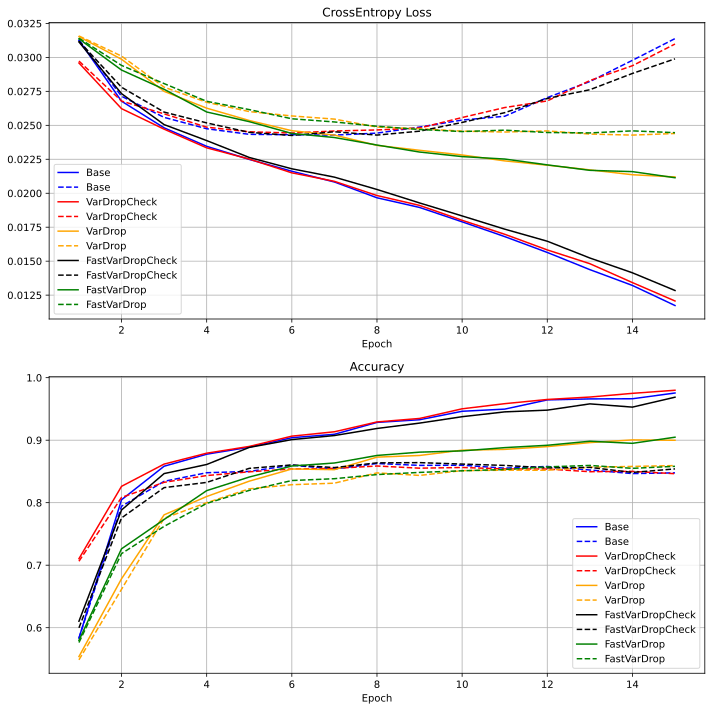

In [105]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE
axes[0].plot(np.arange(1, 16), train_losses_pure, color='blue', ls='-', label='Base')
axes[0].plot(np.arange(1, 16), test_losses_pure, color='blue', ls='--', label='Base')
axes[0].plot(np.arange(1, 16), train_losses_do11, color='r', ls='-', label='VarDropCheck')
axes[0].plot(np.arange(1, 16), test_losses_do11, color='r', ls='--', label='VarDropCheck')
axes[0].plot(np.arange(1, 16), train_losses_do12, color='orange', ls='-', label='VarDrop')
axes[0].plot(np.arange(1, 16), test_losses_do12, color='orange', ls='--', label='VarDrop')
axes[0].plot(np.arange(1, 16), train_losses_do21, color='black', ls='-', label='FastVarDropCheck')
axes[0].plot(np.arange(1, 16), test_losses_do21, color='black', ls='--', label='FastVarDropCheck')
axes[0].plot(np.arange(1, 16), train_losses_do22, color='g', ls='-', label='FastVarDrop')
axes[0].plot(np.arange(1, 16), test_losses_do22, color='g', ls='--', label='FastVarDrop')

axes[1].plot(np.arange(1, 16), train_accuracies_pure, color='blue', ls='-', label='Base')
axes[1].plot(np.arange(1, 16), test_accuracies_pure, color='blue', ls='--', label='Base')
axes[1].plot(np.arange(1, 16), train_accuracies_do11, color='r', ls='-', label='VarDropCheck')
axes[1].plot(np.arange(1, 16), test_accuracies_do11, color='r', ls='--', label='VarDropCheck')
axes[1].plot(np.arange(1, 16), train_accuracies_do12, color='orange', ls='-', label='VarDrop')
axes[1].plot(np.arange(1, 16), test_accuracies_do12, color='orange', ls='--', label='VarDrop')
axes[1].plot(np.arange(1, 16), train_accuracies_do21, color='black', ls='-', label='FastVarDropCheck')
axes[1].plot(np.arange(1, 16), test_accuracies_do21, color='black', ls='--', label='FastVarDropCheck')
axes[1].plot(np.arange(1, 16), train_accuracies_do22, color='g', ls='-', label='FastVarDrop')
axes[1].plot(np.arange(1, 16), test_accuracies_do22, color='g', ls='--', label='FastVarDrop')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**

Наилучшей реализацией DropOut оказалась Fast Variational Dropout. С точки зрения качества на тесте модели примерно равны, но Fast Variational Dropout обучается намного быстрее других реализаций.

## Бонус. Zoneout (2 балла)

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью p компонента скрытого состояния обновляется, а с вероятностью 1-p берется с предыдущего шага. 
В Виде формул (m^t_h - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

# Часть 2. Language Modeling с помощью LSTM. (3 балла)

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации -- конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## Реализация модели и цикла обучения (1 балл)

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [149]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens. Shape: [T, B]
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.tensor: Distribution of next token for each time step. Shape: [T, B, V], V -- size of vocabulary
        """
        # Make embeddings for all tokens
        # YOUR CODE HERE
        
        # Forward pass embeddings through network
        # YOUR CODE HERE
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        # YOUR CODE HERE
        
        pass

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [55]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [54]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [150]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = None
        packed_tokens = None
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        
        pass

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [151]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = None
        packed_tokens = None
        
        pass

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [155]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        
        pass
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            
            pass
            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [29]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
lm_vocab = torchtext.vocab.Vocab(counter, specials=specials, specials_first=True, max_size=30000)

In [30]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [171]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце -- `<eos>` токен.

In [172]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [   1, 1495,   15,  ..., 1498,   37,    4],
         [   1,  383,  296,  ..., 1658,    1,    8],
         ...,
         [ 355,   40,  258,  ...,   39,  347,   53],
         [1294, 4617, 1661,  ...,    6, 9830,  423],
         [   3,    3,    3,  ...,    3,    3,    3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [210]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [211]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [212]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.546/7.682. Accuracy (Train/Test): 0.079/0.079
Epoch: 2/10. Loss (Train/Test): 7.315/7.519. Accuracy (Train/Test): 0.089/0.089
Epoch: 3/10. Loss (Train/Test): 7.108/7.414. Accuracy (Train/Test): 0.097/0.095
Epoch: 4/10. Loss (Train/Test): 6.911/7.334. Accuracy (Train/Test): 0.100/0.097
Epoch: 5/10. Loss (Train/Test): 6.757/7.324. Accuracy (Train/Test): 0.105/0.100
Epoch: 6/10. Loss (Train/Test): 6.555/7.283. Accuracy (Train/Test): 0.109/0.104
Epoch: 7/10. Loss (Train/Test): 6.409/7.294. Accuracy (Train/Test): 0.114/0.106
Epoch: 8/10. Loss (Train/Test): 6.242/7.287. Accuracy (Train/Test): 0.120/0.108
Epoch: 9/10. Loss (Train/Test): 6.085/7.304. Accuracy (Train/Test): 0.123/0.109
Epoch: 10/10. Loss (Train/Test): 5.940/7.341. Accuracy (Train/Test): 0.128/0.110


## Реализация декодера. (2 балла)

Теперь, реализуем последнюю деталь -- декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [230]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :return Tuple[torch.tensor, torch.tensor]. Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = None
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        pass
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = None
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = None
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = None
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Evaluate embedding for next token
        # YOUR CODE HERE

        # Update hidden and cell states
        # YOUR CODE HERE

    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [231]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [232]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [233]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.itos)[np.array(tokens)]
    print(' '.join(words))

<sos> first saw movie first time really disappointed really disappointed movie even one funniest films ever seen movie seen life <eos>
<sos> <unk> favorite movie ever seen movie really enjoyed first saw movie years ago thought would good movie <eos>
<sos> <unk> best movie ever seen movie ever made one thing bad acting bad acting bad effects bad bad script bad script bad acting
<sos> <unk> worst movie ever seen life life <unk> one best movies ever seen bad movies bad acting bad acting bad <eos>


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [1]:
# YOUR CODE HERE

**Ответ:**

## Бонус. Cущественное улучшение качества. (до 3 баллов)

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов
2. Dropout входов и выходов RNN
3. Регуляризация активаций (AR/TAR)
4. NT-ASGD
5. Tied веса эмбеддингов и софтмакса